# Lecture 02: Density-Based Clustering

## Learning Objectives
By the end of this lecture, you will be able to:
- Understand DBSCAN algorithm and its parameters
- Apply DBSCAN to datasets with arbitrary cluster shapes
- Understand the difference between core, border, and noise points
- Compare density-based clustering with K-means
- Choose appropriate parameters (eps and min_samples)

**Prerequisites:** Basic understanding of clustering, distance metrics

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
print('✓ Ready for Density-Based Clustering!')

✓ Ready for Density-Based Clustering!


## 1. Why Density-Based Clustering?

### The Problem with K-Means

K-means assumes **spherical clusters** of similar size. But real data often has:
- **Arbitrary shapes** (crescents, rings, elongated)
- **Different densities**
- **Noise and outliers**

Let's see where K-means fails:

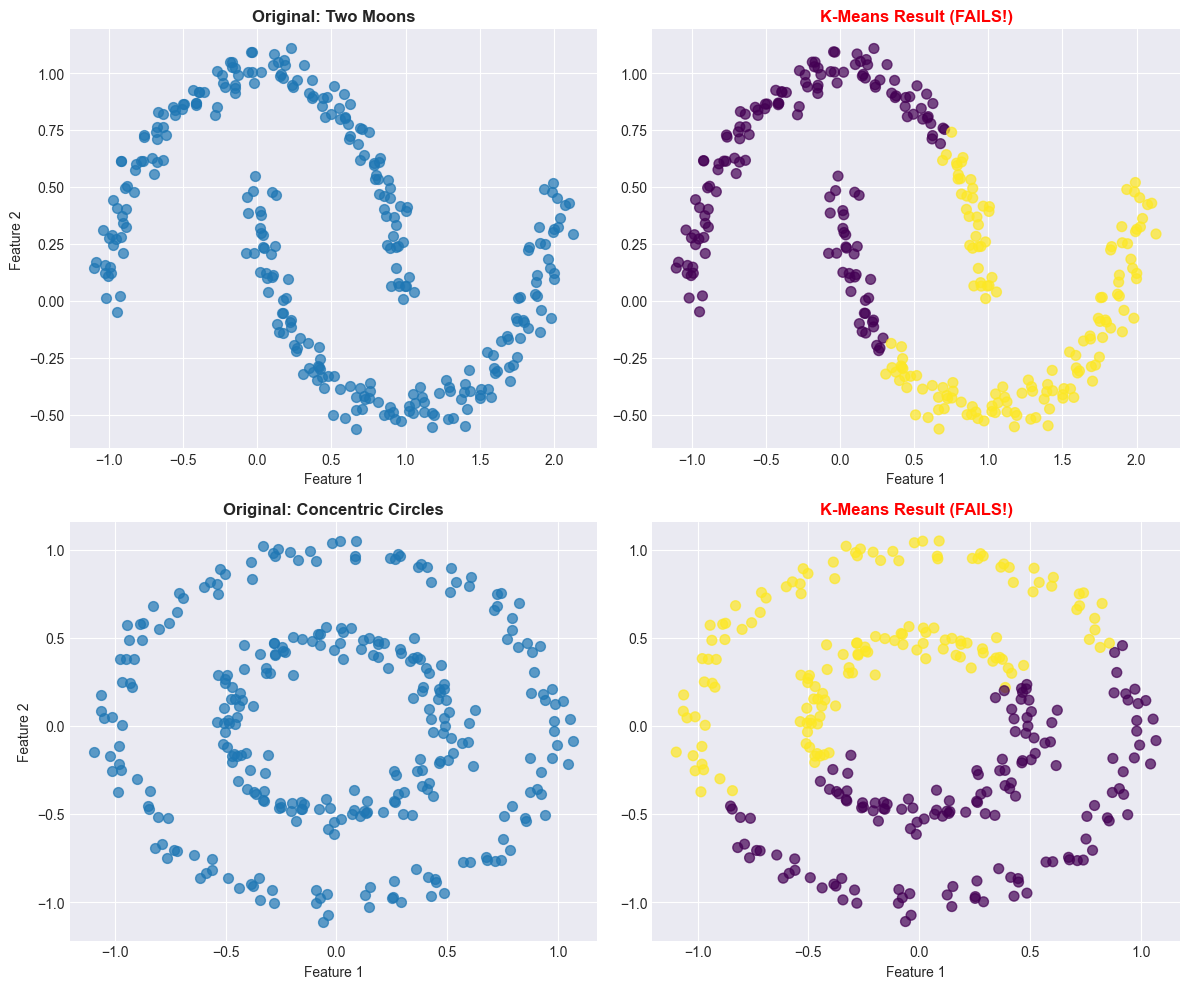

❌ K-means cannot handle non-spherical shapes!


In [2]:
# Generate non-spherical data
X_moons, _ = make_moons(n_samples=300, noise=0.05, random_state=42)
X_circles, _ = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

# Try K-means on both
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Moons - Original
axes[0, 0].scatter(X_moons[:, 0], X_moons[:, 1], s=50, alpha=0.7)
axes[0, 0].set_title('Original: Two Moons', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

# Moons - K-means (fails!)
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
y_kmeans_moons = kmeans_moons.fit_predict(X_moons)
axes[0, 1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_kmeans_moons, s=50, alpha=0.7, cmap='viridis')
axes[0, 1].set_title('K-Means Result (FAILS!)', fontsize=12, fontweight='bold', color='red')
axes[0, 1].set_xlabel('Feature 1')

# Circles - Original
axes[1, 0].scatter(X_circles[:, 0], X_circles[:, 1], s=50, alpha=0.7)
axes[1, 0].set_title('Original: Concentric Circles', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Feature 1')
axes[1, 0].set_ylabel('Feature 2')

# Circles - K-means (fails!)
kmeans_circles = KMeans(n_clusters=2, random_state=42, n_init=10)
y_kmeans_circles = kmeans_circles.fit_predict(X_circles)
axes[1, 1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_kmeans_circles, s=50, alpha=0.7, cmap='viridis')
axes[1, 1].set_title('K-Means Result (FAILS!)', fontsize=12, fontweight='bold', color='red')
axes[1, 1].set_xlabel('Feature 1')

plt.tight_layout()
plt.show()

print("❌ K-means cannot handle non-spherical shapes!")

## 2. DBSCAN: Density-Based Spatial Clustering

### Core Idea

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**

**Key Insight:** Clusters are dense regions separated by sparse regions.

### Algorithm Concepts

**Two Parameters:**
1. **eps (ε):** Maximum distance between two points to be neighbors
2. **min_samples:** Minimum points needed to form a dense region

**Three Types of Points:**
1. **Core point:** Has ≥ min_samples within eps distance
2. **Border point:** Within eps of a core point, but not a core itself
3. **Noise point:** Neither core nor border (outlier!)

### Visual Explanation

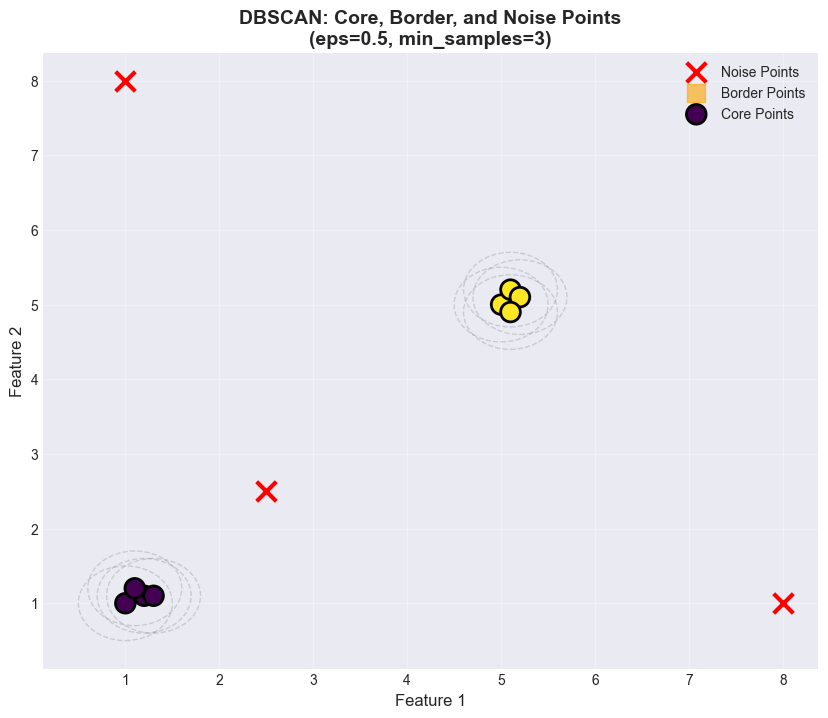


Results:
  Core points: 8
  Border points: 0
  Noise points: 3
  Number of clusters: 2


In [3]:
# Create simple dataset to demonstrate concepts
np.random.seed(42)
X_demo = np.array([
    [1, 1], [1.2, 1.1], [1.1, 1.2], [1.3, 1.1],  # Cluster 1 (dense)
    [5, 5], [5.1, 5.2], [5.2, 5.1], [5.1, 4.9],  # Cluster 2 (dense)
    [2.5, 2.5],  # Border point
    [8, 1], [1, 8]  # Noise points (outliers)
])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
labels = dbscan.fit_predict(X_demo)

# Identify point types
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

# Plot noise points
noise = labels == -1
ax.scatter(X_demo[noise, 0], X_demo[noise, 1], 
           c='red', marker='x', s=200, linewidths=3,
           label='Noise Points', zorder=3)

# Plot border points
border = (labels >= 0) & ~core_samples_mask
ax.scatter(X_demo[border, 0], X_demo[border, 1],
           c='orange', marker='s', s=150, alpha=0.6,
           label='Border Points', zorder=2)

# Plot core points
core = core_samples_mask
ax.scatter(X_demo[core, 0], X_demo[core, 1],
           c=labels[core], cmap='viridis', marker='o', s=200,
           edgecolors='black', linewidth=2,
           label='Core Points', zorder=3)

# Draw eps circles around core points
for point in X_demo[core]:
    circle = plt.Circle(point, 0.5, color='gray', fill=False, 
                       linestyle='--', linewidth=1, alpha=0.3)
    ax.add_patch(circle)

ax.set_xlabel('Feature 1', fontsize=12)
ax.set_ylabel('Feature 2', fontsize=12)
ax.set_title('DBSCAN: Core, Border, and Noise Points\n(eps=0.5, min_samples=3)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

print(f"\nResults:")
print(f"  Core points: {core.sum()}")
print(f"  Border points: {border.sum()}")
print(f"  Noise points: {noise.sum()}")
print(f"  Number of clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

## 3. DBSCAN on Non-Spherical Data

Now let's apply DBSCAN to the datasets where K-means failed:

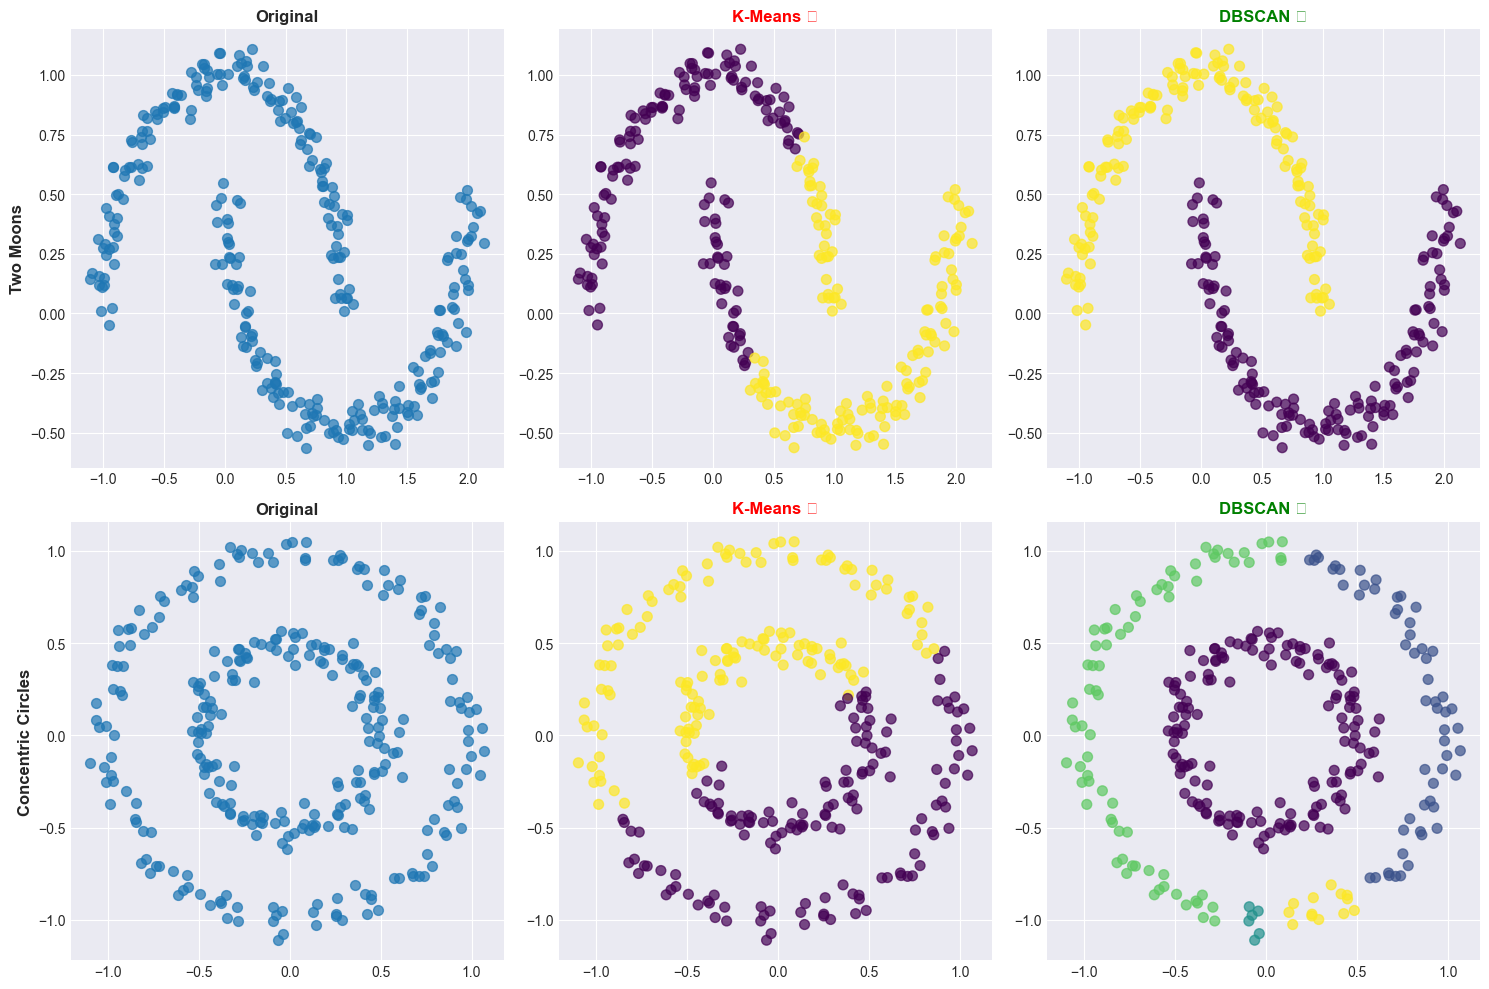

✓ DBSCAN successfully finds clusters with arbitrary shapes!


In [4]:
# Apply DBSCAN to moons and circles
dbscan_moons = DBSCAN(eps=0.2, min_samples=5)
y_dbscan_moons = dbscan_moons.fit_predict(X_moons)

dbscan_circles = DBSCAN(eps=0.15, min_samples=5)
y_dbscan_circles = dbscan_circles.fit_predict(X_circles)

# Plotting comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Moons
axes[0, 0].scatter(X_moons[:, 0], X_moons[:, 1], s=50, alpha=0.7)
axes[0, 0].set_title('Original', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Two Moons', fontsize=12, fontweight='bold')

axes[0, 1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_kmeans_moons, s=50, alpha=0.7, cmap='viridis')
axes[0, 1].set_title('K-Means ❌', fontsize=12, fontweight='bold', color='red')

axes[0, 2].scatter(X_moons[:, 0], X_moons[:, 1], c=y_dbscan_moons, s=50, alpha=0.7, cmap='viridis')
axes[0, 2].set_title('DBSCAN ✓', fontsize=12, fontweight='bold', color='green')

# Circles
axes[1, 0].scatter(X_circles[:, 0], X_circles[:, 1], s=50, alpha=0.7)
axes[1, 0].set_title('Original', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Concentric Circles', fontsize=12, fontweight='bold')

axes[1, 1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_kmeans_circles, s=50, alpha=0.7, cmap='viridis')
axes[1, 1].set_title('K-Means ❌', fontsize=12, fontweight='bold', color='red')

axes[1, 2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_dbscan_circles, s=50, alpha=0.7, cmap='viridis')
axes[1, 2].set_title('DBSCAN ✓', fontsize=12, fontweight='bold', color='green')

plt.tight_layout()
plt.show()

print("✓ DBSCAN successfully finds clusters with arbitrary shapes!")

## 4. Parameter Selection: eps and min_samples

### How to Choose eps?

**Method: k-distance plot**

1. For each point, compute distance to k-th nearest neighbor
2. Sort these distances
3. Plot them
4. Look for "elbow" → good eps value

**Rule of thumb for min_samples:**
- Start with `min_samples = 2 × dimensions`
- For 2D data: min_samples = 4 or 5
- Increase for noisy data

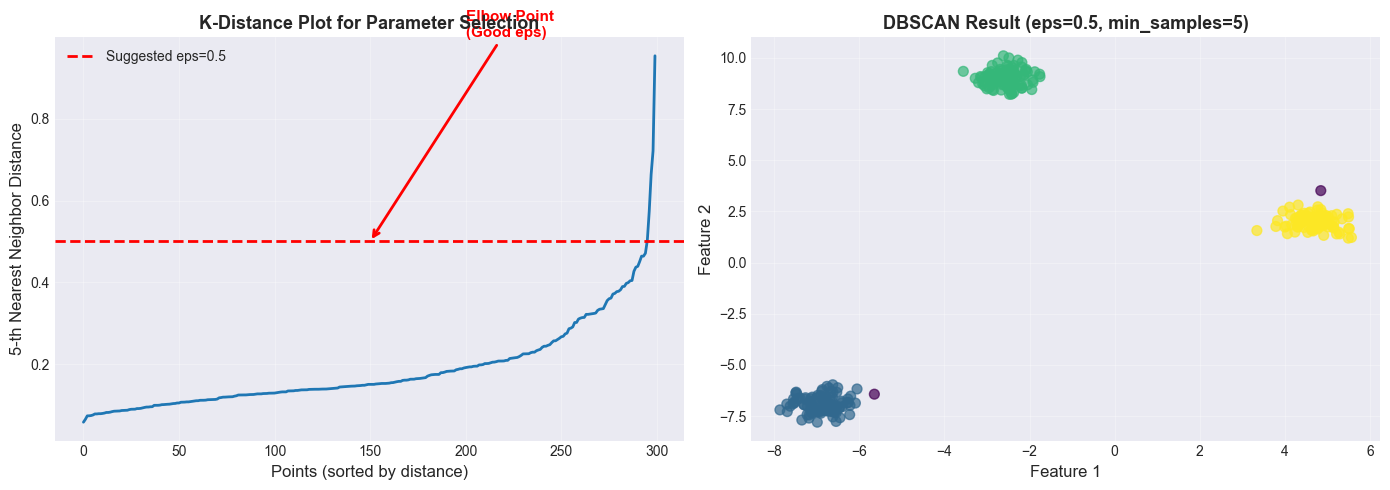


Results with eps=0.5, min_samples=5:
  Clusters found: 3
  Noise points: 2


In [5]:
# Generate test data
X_test, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.4, random_state=42)

# Compute k-distance plot
k = 5  # min_samples candidate
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_test)
distances, indices = neighbors.kneighbors(X_test)

# Sort distances to k-th nearest neighbor
k_distances = distances[:, k-1]
k_distances_sorted = np.sort(k_distances)

# Plot k-distance plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-distance plot
axes[0].plot(k_distances_sorted, linewidth=2)
axes[0].axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Suggested eps=0.5')
axes[0].set_xlabel('Points (sorted by distance)', fontsize=12)
axes[0].set_ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
axes[0].set_title('K-Distance Plot for Parameter Selection', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].annotate('Elbow Point\n(Good eps)', xy=(150, 0.5), xytext=(200, 1.0),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=11, fontweight='bold', color='red')

# Apply DBSCAN with chosen parameters
dbscan_test = DBSCAN(eps=0.5, min_samples=5)
labels_test = dbscan_test.fit_predict(X_test)

axes[1].scatter(X_test[:, 0], X_test[:, 1], c=labels_test, s=50, alpha=0.7, cmap='viridis')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('DBSCAN Result (eps=0.5, min_samples=5)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_clusters = len(set(labels_test)) - (1 if -1 in labels_test else 0)
n_noise = list(labels_test).count(-1)
print(f"\nResults with eps=0.5, min_samples=5:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise}")

## 5. Effect of Parameter Changes

Let's see how different parameter values affect clustering:

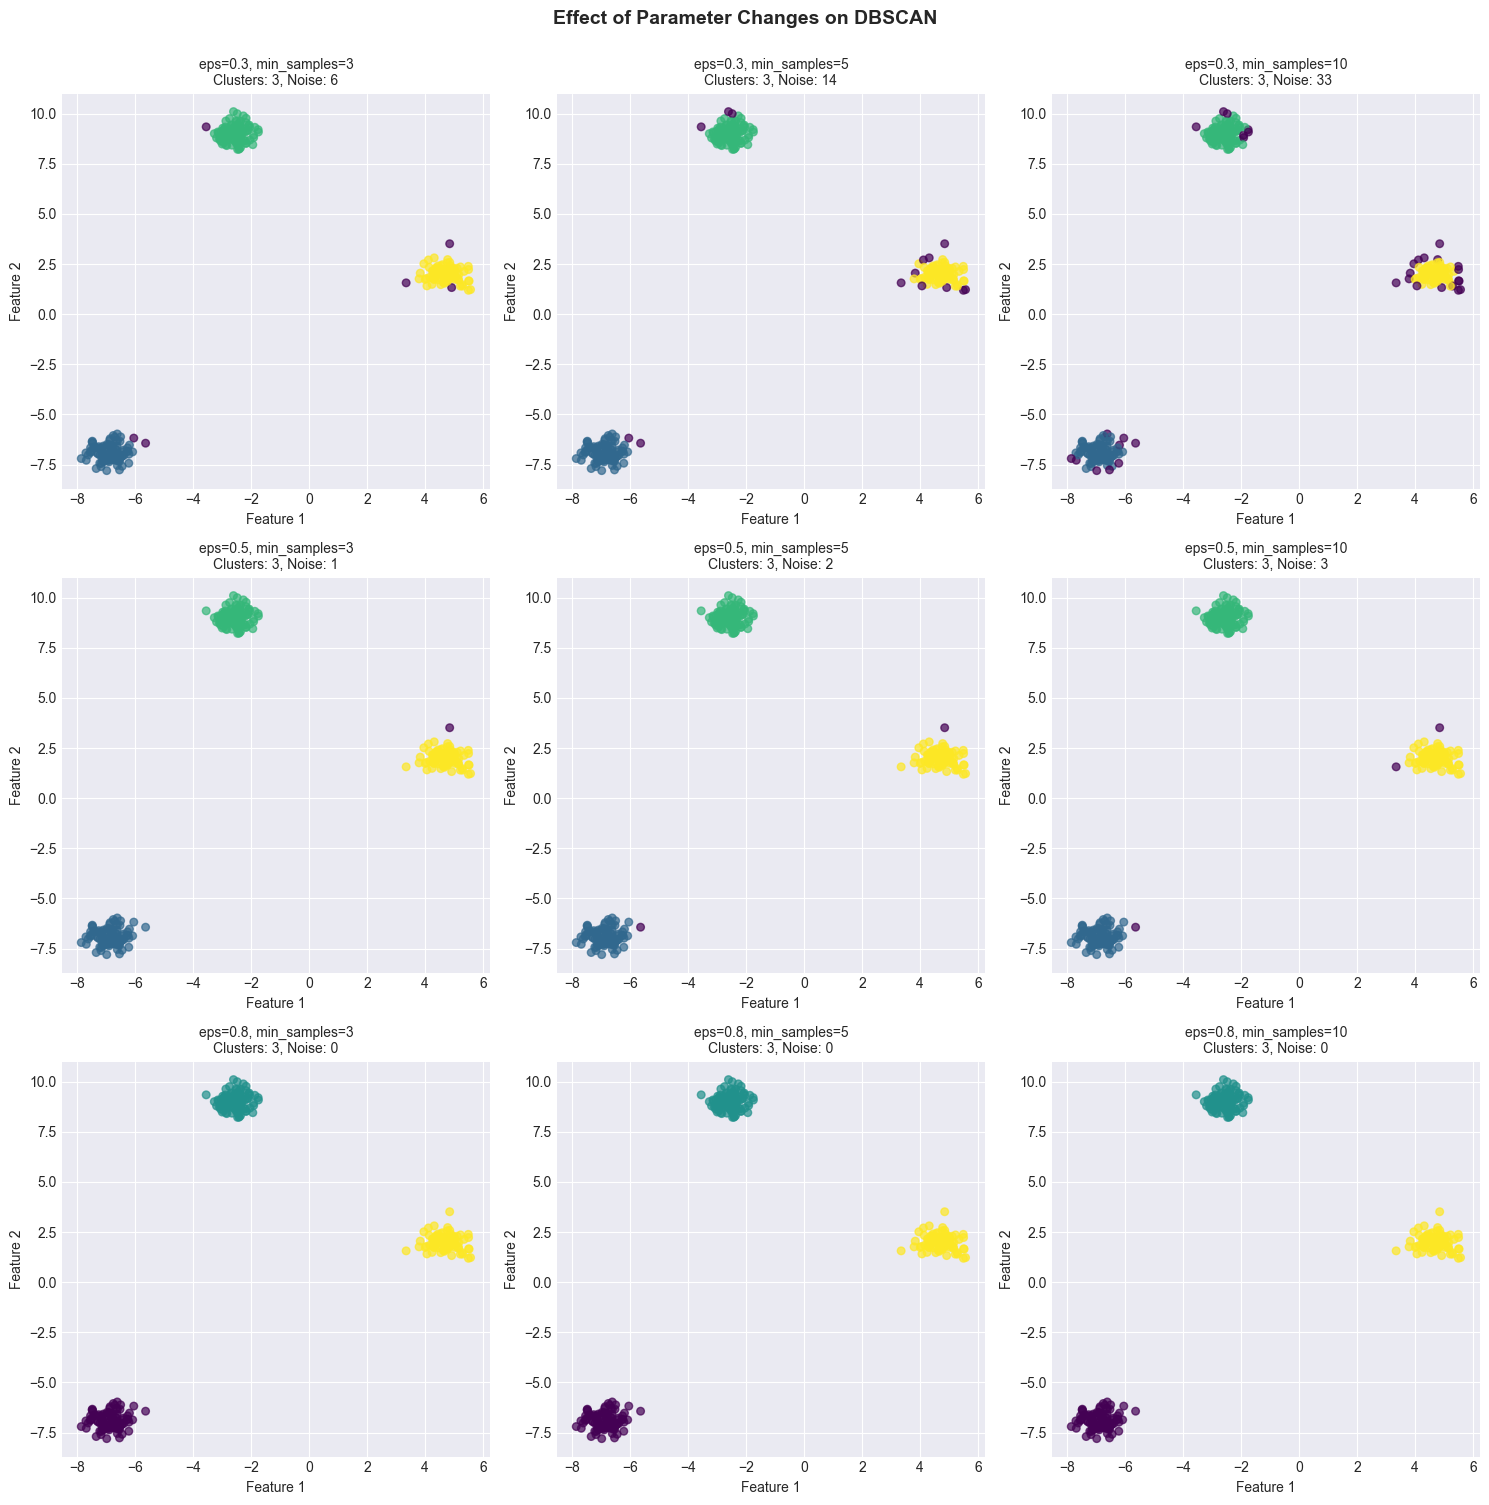


📊 Observations:
  • Small eps → More clusters, more noise
  • Large eps → Fewer clusters, less noise
  • Small min_samples → More points are core points
  • Large min_samples → More noise points


In [6]:
# Test different parameter combinations
eps_values = [0.3, 0.5, 0.8]
min_samples_values = [3, 5, 10]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, eps in enumerate(eps_values):
    for j, min_samp in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        labels = dbscan.fit_predict(X_test)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        axes[i, j].scatter(X_test[:, 0], X_test[:, 1], c=labels, s=30, alpha=0.7, cmap='viridis')
        axes[i, j].set_title(f'eps={eps}, min_samples={min_samp}\nClusters: {n_clusters}, Noise: {n_noise}',
                            fontsize=10)
        axes[i, j].set_xlabel('Feature 1')
        axes[i, j].set_ylabel('Feature 2')

plt.suptitle('Effect of Parameter Changes on DBSCAN', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  • Small eps → More clusters, more noise")
print("  • Large eps → Fewer clusters, less noise")
print("  • Small min_samples → More points are core points")
print("  • Large min_samples → More noise points")

## 6. Real-World Example: Customer Location Clustering

Imagine we have customer locations and want to find dense areas (potential store locations):

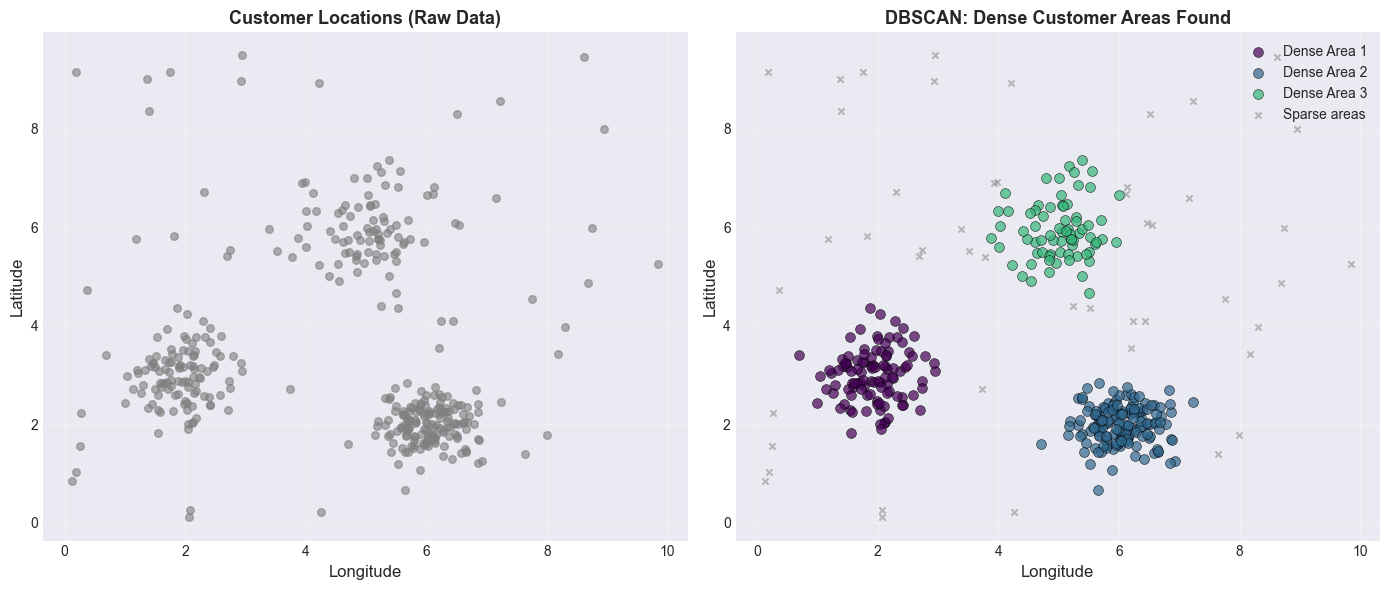


📍 Business Insights:
  • Found 3 dense customer areas (potential store locations)
  • 48 customers in sparse areas (online delivery focus)
  • 332 customers near dense areas


In [7]:
# Simulate customer locations with noise
np.random.seed(42)

# Three main shopping areas
area1 = np.random.randn(100, 2) * 0.5 + [2, 3]
area2 = np.random.randn(150, 2) * 0.4 + [6, 2]
area3 = np.random.randn(80, 2) * 0.6 + [5, 6]

# Random customers (sparse)
random_customers = np.random.rand(50, 2) * 10

X_customers = np.vstack([area1, area2, area3, random_customers])

# Scale the data (important!)
scaler = StandardScaler()
X_customers_scaled = scaler.fit_transform(X_customers)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=10)
labels = dbscan.fit_predict(X_customers_scaled)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before clustering
axes[0].scatter(X_customers[:, 0], X_customers[:, 1], s=30, alpha=0.6, c='gray')
axes[0].set_xlabel('Longitude', fontsize=12)
axes[0].set_ylabel('Latitude', fontsize=12)
axes[0].set_title('Customer Locations (Raw Data)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# After clustering
unique_labels = set(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Noise points
        mask = labels == label
        axes[1].scatter(X_customers[mask, 0], X_customers[mask, 1],
                       s=20, c='gray', marker='x', alpha=0.5, label='Sparse areas')
    else:
        # Cluster points
        mask = labels == label
        axes[1].scatter(X_customers[mask, 0], X_customers[mask, 1],
                       s=50, c=[color], alpha=0.7, edgecolors='black', linewidth=0.5,
                       label=f'Dense Area {label+1}')

axes[1].set_xlabel('Longitude', fontsize=12)
axes[1].set_ylabel('Latitude', fontsize=12)
axes[1].set_title('DBSCAN: Dense Customer Areas Found', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"\n📍 Business Insights:")
print(f"  • Found {n_clusters} dense customer areas (potential store locations)")
print(f"  • {n_noise} customers in sparse areas (online delivery focus)")
print(f"  • {len(X_customers) - n_noise} customers near dense areas")

## 7. DBSCAN vs K-Means: Summary

| Aspect | K-Means | DBSCAN |
|--------|---------|--------|
| **Cluster Shape** | Spherical only | Any shape |
| **Parameter** | k (number of clusters) | eps, min_samples |
| **Outliers** | Assigns to nearest cluster | Marks as noise |
| **Speed** | Fast O(n) | Slower O(n log n) |
| **Varying Density** | No | Sometimes struggles |
| **Use When** | Spherical, equal size | Arbitrary shapes, outliers |

### Advantages of DBSCAN

✅ **Finds clusters of arbitrary shape**

✅ **Identifies outliers (noise)**

✅ **No need to specify number of clusters**

✅ **Robust to outliers**

### Disadvantages of DBSCAN

❌ **Struggles with varying densities**

❌ **Parameter tuning can be tricky**

❌ **Not deterministic with border points**

❌ **Slower than K-means**

## 8. Practical Tips

### DO's ✓

1. **Always scale your features** before DBSCAN
2. **Use k-distance plot** to choose eps
3. **Start with min_samples = 2 × dimensions**
4. **Visualize results** to validate
5. **Try different parameters** and compare

### DON'Ts ✗

1. **Don't use without scaling** (different feature ranges)
2. **Don't expect perfect on varying densities**
3. **Don't ignore noise points** (they might be important!)
4. **Don't use single parameter set** without exploration

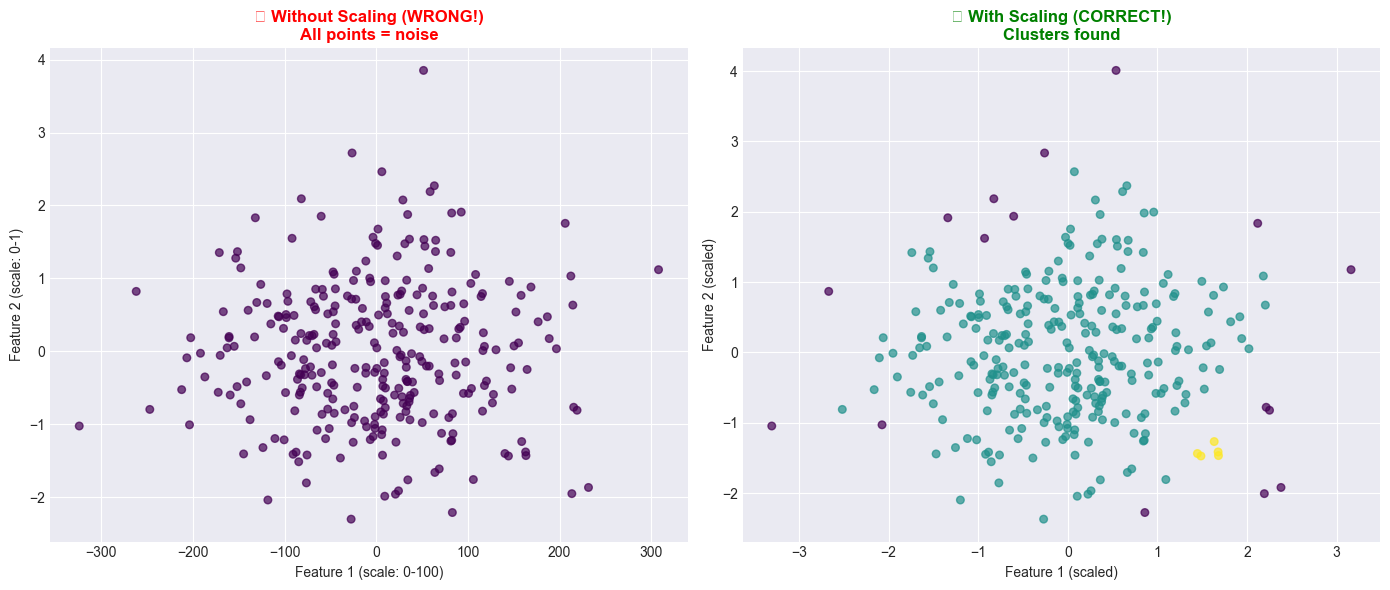


⚠️  Always scale your features before DBSCAN!


In [8]:
# Example: Common mistake - not scaling
np.random.seed(42)
X_unscaled = np.random.randn(300, 2)
X_unscaled[:, 0] *= 100  # First feature has much larger scale
X_unscaled[:, 1] *= 1    # Second feature has small scale

# Without scaling
dbscan_wrong = DBSCAN(eps=0.5, min_samples=5)
labels_wrong = dbscan_wrong.fit_predict(X_unscaled)

# With scaling
X_scaled = StandardScaler().fit_transform(X_unscaled)
dbscan_right = DBSCAN(eps=0.5, min_samples=5)
labels_right = dbscan_right.fit_predict(X_scaled)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_unscaled[:, 0], X_unscaled[:, 1], c=labels_wrong, s=30, alpha=0.7, cmap='viridis')
axes[0].set_title('❌ Without Scaling (WRONG!)\nAll points = noise', 
                 fontsize=12, fontweight='bold', color='red')
axes[0].set_xlabel('Feature 1 (scale: 0-100)')
axes[0].set_ylabel('Feature 2 (scale: 0-1)')

axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_right, s=30, alpha=0.7, cmap='viridis')
axes[1].set_title('✓ With Scaling (CORRECT!)\nClusters found', 
                 fontsize=12, fontweight='bold', color='green')
axes[1].set_xlabel('Feature 1 (scaled)')
axes[1].set_ylabel('Feature 2 (scaled)')

plt.tight_layout()
plt.show()

print("\n⚠️  Always scale your features before DBSCAN!")

## Summary

### Key Takeaways

1. **DBSCAN finds clusters based on density**, not distance to centroids

2. **Three point types:** Core, border, noise

3. **Two parameters:** eps (neighborhood size), min_samples (density threshold)

4. **Advantages:** Arbitrary shapes, finds outliers, no k needed

5. **Disadvantages:** Varying density issues, parameter tuning

6. **Always scale features!**

### When to Use DBSCAN

✓ Non-spherical cluster shapes

✓ Unknown number of clusters

✓ Need to identify outliers

✓ Clusters have similar density

### When NOT to Use DBSCAN

✗ Clusters have very different densities

✗ High-dimensional data (curse of dimensionality)

✗ Need very fast clustering

✗ Spherical clusters (use K-means instead)

## Next Steps

In the next lecture, we'll explore:
- **Dimensionality Reduction** (PCA, UMAP)
- Visualizing high-dimensional data
- Combining with clustering

**Practice:** Apply DBSCAN to your own datasets in the lab!